In [10]:
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


# Use a whit background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = "#ffffff"

In [3]:
dataset = MNIST(root="data/", download=True, transform= ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 101249089.79it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24241683.78it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28114865.41it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10999150.56it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128


In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images shapes:  torch.Size([128, 1, 28, 28])


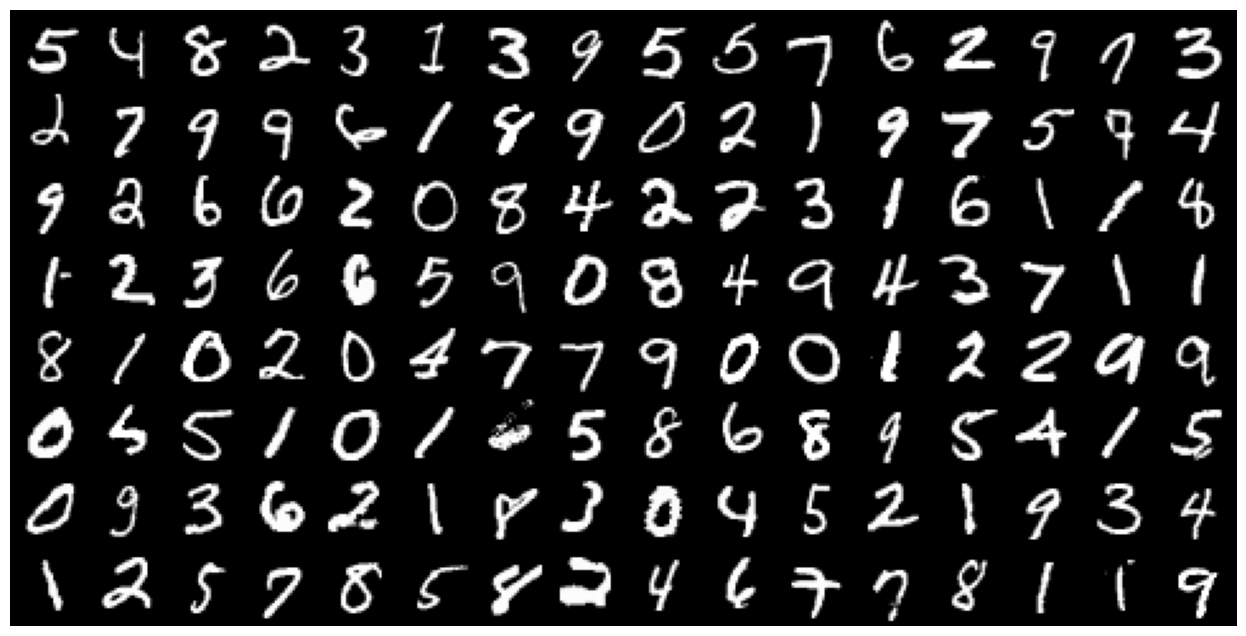

In [8]:
for image, _ in train_loader:
  print("images shapes: ", image.shape)
  plt.figure(figsize=(16,8))
  plt.axis("off")
  plt.imshow(make_grid(image, nrow=16).permute((1,2,0)))
  break

In [11]:
for images, labels in train_loader:
  print("image shapes:", images.shape)
  inputs = images.reshape(-1,784)
  print("input shapes", inputs.shape)
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


image shapes: torch.Size([128, 1, 28, 28])
input shapes torch.Size([128, 784])


In [12]:
input_size = inputs.shape[-1]
hidden_size = 32

In [13]:
input_size

784

In [15]:
layer1 = nn.Linear(input_size, hidden_size)

In [16]:
layer1_outputs = layer1(inputs)
print("layer1_outputs shape: ", layer1_outputs.shape)

layer1_outputs shape:  torch.Size([128, 32])


In [17]:
inputs.shape

torch.Size([128, 784])

In [18]:
torch.allclose(layer1_outputs, inputs @ layer1.weight.t() + layer1.bias)

True

In [19]:
F.relu(torch.tensor([[1,-1,0],
                     [-0.1, 0.2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [21]:
relu_outputs = F.relu(layer1_outputs)
print("min(layer1_outputs): ", torch.min(layer1_outputs).item())
print("min(relu_output):", torch.min(relu_outputs).item())

min(layer1_outputs):  -0.6766504645347595
min(relu_output): 0.0


In [22]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [23]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [24]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3097, grad_fn=<NllLossBackward0>)

In [28]:
# expand version of layer2 (F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [30]:
outputs.shape

torch.Size([128, 10])

In [32]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [33]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias# with activation function

In [34]:
outputs2.shape

torch.Size([128, 10])

In [57]:
def accuracy(outputs, labels):
  _, pred = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(pred==labels).item()/ len(pred))

In [35]:
class MnistModel(nn.Module):
  """ Feedforward neural network with 1 hidden layer"""
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    # flatten the image tensors
    xb = xb.view(xb.size(0), -1)
    # Get intermiadate outputs using hidden layer
    out = self.linear1(xb)
    # apply activation function
    out = F.relu(out)
    # get prediction using output layer
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)        # Generate prediction
    loss = F.cross_entropy(out, labels)# calculate loss
    return loss


  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss, "val_acc": acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss": epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}, val_acc : {result['val_acc']:.4f}")

In [38]:
input_size = 784
hidden_size = 32
num_classes = 10

In [39]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)

In [40]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [41]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print("Loss: ", loss.item())
  break

print("outputs.shape :", outputs.shape)
print("sample outputs :\n", outputs[:2].data)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss:  2.322267532348633
outputs.shape : torch.Size([128, 10])
sample outputs :
 tensor([[ 0.0110,  0.1978, -0.3060,  0.1531,  0.1022, -0.0748, -0.0412, -0.1576,
         -0.0272, -0.0193],
        [-0.0539,  0.0882, -0.3758,  0.2290,  0.1456, -0.0269,  0.0287, -0.1697,
         -0.0087,  0.1170]])


Using Gpu

In [42]:
torch.cuda.is_available()

True

In [43]:
def get_default_device():
  """
  Pick Gpu if available , else cpu
  """
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

In [44]:
device = get_default_device()
device

device(type='cuda')

In [45]:
def to_device(data, device):
  # Move tensor to choosen devices
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  

In [47]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cuda:0


In [48]:
class DeviceDataLoader():
  # wrap a datalaoder to move data to a device
  def __init__(self, d1, device):
    self.d1 = d1
    self.device = device

  def __iter__(self):
    # yield a batch of data after moving it to device
    for b in self.d1:
      yield to_device(b, self.device)

  def __len__(self):
    # number of batches
    return len(self.d1)

In [49]:
def some_numbers():
  yield 10
  yield 20
  yield 30

for value in some_numbers():
  print(value)

10
20
30


In [50]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [51]:
for xb,yb in val_loader:
  print("xb.device", xb.device)
  print('yb:',yb)
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


xb.device cuda:0
yb: tensor([9, 4, 7, 3, 4, 1, 1, 4, 7, 0, 3, 3, 4, 4, 5, 3, 6, 2, 9, 8, 8, 7, 1, 3,
        1, 1, 1, 2, 6, 6, 4, 9, 3, 9, 1, 8, 4, 0, 9, 6, 3, 4, 0, 9, 4, 3, 2, 4,
        3, 9, 7, 2, 9, 0, 7, 1, 5, 9, 7, 9, 0, 8, 1, 7, 9, 6, 7, 4, 8, 0, 1, 5,
        1, 3, 4, 2, 3, 8, 8, 8, 0, 1, 9, 9, 1, 2, 6, 3, 1, 6, 5, 1, 1, 8, 2, 5,
        1, 1, 9, 8, 9, 0, 7, 9, 2, 4, 3, 9, 3, 5, 6, 8, 4, 9, 0, 5, 2, 3, 8, 4,
        0, 6, 7, 6, 6, 8, 6, 9, 4, 3, 6, 4, 3, 0, 1, 3, 7, 5, 2, 5, 2, 7, 4, 7,
        7, 9, 8, 5, 5, 7, 3, 6, 7, 6, 9, 9, 5, 6, 0, 8, 9, 7, 0, 3, 9, 8, 4, 7,
        8, 3, 8, 1, 8, 9, 5, 8, 2, 1, 7, 2, 9, 8, 5, 9, 6, 5, 4, 8, 7, 2, 0, 4,
        9, 7, 2, 9, 1, 6, 2, 3, 4, 8, 6, 2, 2, 8, 0, 3, 3, 1, 5, 7, 0, 2, 6, 5,
        3, 2, 8, 6, 9, 9, 0, 4, 5, 6, 5, 7, 6, 9, 2, 5, 7, 1, 9, 3, 6, 6, 9, 1,
        5, 0, 1, 3, 5, 1, 3, 5, 0, 5, 4, 9, 8, 0, 4, 0], device='cuda:0')


In [66]:
from torch.optim import optimizer
def evaluate(model, val_loader):
  """Evaluate the model performance on the validation on the validation dataset"""
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  """Train the model using gradient descent"""
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [55]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size = num_classes)
to_device(model, device)


MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [58]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3146400451660156, 'val_acc': 0.09765625}]

In [67]:
history += fit(5,0.5, model,train_loader, val_loader)

Epoch [0], val_loss: 0.2408, val_acc : 0.9280
Epoch [1], val_loss: 0.1742, val_acc : 0.9466
Epoch [2], val_loss: 0.1466, val_acc : 0.9570
Epoch [3], val_loss: 0.1507, val_acc : 0.9532
Epoch [4], val_loss: 0.1232, val_acc : 0.9609


In [68]:
history += fit(5,0.5, model,train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 0.1325, val_acc : 0.9602
Epoch [1], val_loss: 0.1209, val_acc : 0.9615
Epoch [2], val_loss: 0.1255, val_acc : 0.9601
Epoch [3], val_loss: 0.1218, val_acc : 0.9625
Epoch [4], val_loss: 0.1405, val_acc : 0.9576


In [72]:
history += fit(5,0.1, model,train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 0.1056, val_acc : 0.9684
Epoch [1], val_loss: 0.1065, val_acc : 0.9674
Epoch [2], val_loss: 0.1070, val_acc : 0.9676
Epoch [3], val_loss: 0.1094, val_acc : 0.9670
Epoch [4], val_loss: 0.1082, val_acc : 0.9681


Text(0, 0.5, 'loss')

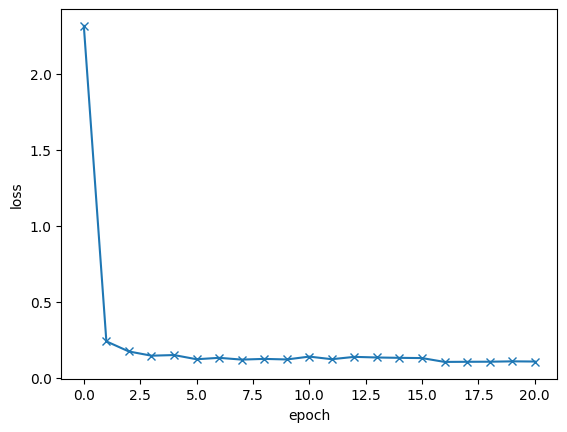

In [73]:
losses = [x["val_loss"] for x in history]
plt.plot(losses, "-x")
plt.xlabel("epoch")
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

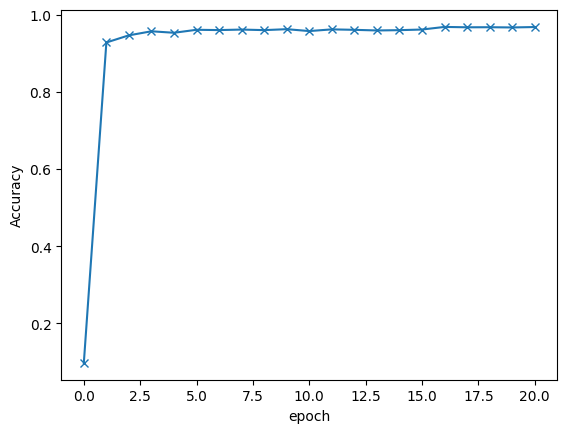

In [74]:
acc= [x["val_acc"] for x in history]
plt.plot(acc, "-x")
plt.xlabel("epoch")
plt.ylabel('Accuracy')

In [75]:
from torch.nn.modules.transformer import Transformer
test_dataset = MNIST(root="data/", train=False, transform = ToTensor())


In [76]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, pred = torch.max(yb, dim=1)
  return pred[0].item()

Label:  7 , Predicated :  7


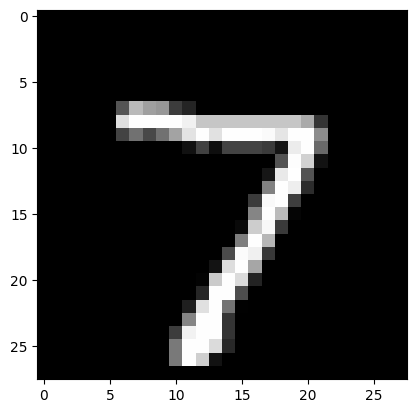

In [77]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print("Label: ", label, ", Predicated : ", predict_image(img, model))


Label:  2 , Predicated :  2


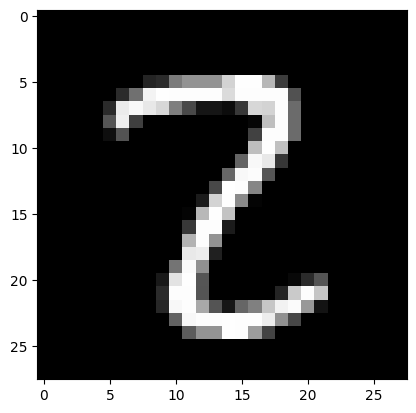

In [78]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print("Label: ", label, ", Predicated : ", predict_image(img, model))


Label:  9 , Predicated :  9


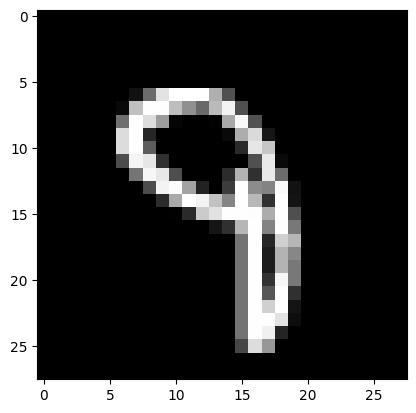

In [79]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print("Label: ", label, ", Predicated : ", predict_image(img, model))


In [80]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size= 256), device)
result = evaluate(model, test_loader)
result


{'val_loss': 0.09612692147493362, 'val_acc': 0.97265625}